In [16]:
import cv2
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import math

In [17]:
img = io.imread('F1-6.jpg')
#convert img to grey
img_grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#set a thresh
thresh = 150
#get threshold image
ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)

In [18]:
# this function takes the threshold images and preduce the approximated shapes for them
def PolyApproxMethod(image, approx_factor):
    # Empty array for the approximated images
    approximated_images = []
    # Get the contours for the whole image
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # loop over each contour to calculate the approximated shape
    for contour in contours:
        percentage = approx_factor * cv2.arcLength(contour, True)
        approximated_shape = cv2.approxPolyDP(contour, percentage, False)
        approximated_shape.shape = (len(approximated_shape), 2)
        approximated_images.append(approximated_shape)
    return approximated_images


In [19]:
# angles are rad and they can be negative
def cold_ang_mag(x1,y1,x2,y2):
    r = abs( np.sqrt( np.power(y2-y1,2) + np.power(x2-x1,2) ) )
    if(x2-x1 == 0):
        theta = (y2-y1)/(abs(y2-y1))*np.pi/2
    elif(x2-x1 <0):
        theta = (math.atan((y2-y1)/(x2-x1)) + np.pi)
    else:
        theta = math.atan((y2-y1)/(x2-x1)) 
    if(theta < 0):
        theta = theta + 2*np.pi 
    if(theta*180/np.pi  > 180.0):
        theta = theta -2*np.pi
    #theta = theta*180/np.pi            #to see the decimal angle
    return r,theta
    
def distribution(arr): # arr: the array containing dominant points
    distrib =[]
    for shape in arr:
        for i in range(len(shape)-1):
            distrib.append(list(cold_ang_mag(shape[i][0],shape[i][1],shape[i+1][0],shape[i+1][1])))
    return np.asarray(distrib)      # array of the r and theta for the lines (size less by one to number of points)

def convertPolarToSpatial(polarCoordArr):
    spatialCoord = [[i[0] * math.cos(i[1]), i[0] * math.sin(i[1])] for i in polarCoordArr]
    return np.asarray(spatialCoord)

def calculateFeatureVector(distribution, numOfRhos = 7, numOfAngels = 12):
    # histogram of the feature vector
    hist = np.zeros((numOfRhos, numOfAngels), dtype=int)
    # angle bin size
    angle_bin_size = 360 / numOfAngels
    # min value of the rho
    r_inner = 5
    # max value of the rho
    r_outter = 35
    # get the logarithmic rhos
    rhos = np.log10(distribution[:, 0])
    # get the thetas
    thetas = np.asarray(distribution[:, 1])
    # generate the logarithmic quantization levels
    rho_levels = np.log10(np.linspace(r_inner, r_outter, numOfRhos))
    # quantized values
    quantized_values = np.zeros(rhos.shape, dtype = int)
    for i in range(numOfRhos):
        quantized_values += (rhos < rho_levels[i])
    for i, r_bin in enumerate(quantized_values):
        theta_bin = int(thetas[i] // angle_bin_size) % numOfAngels
        hist[r_bin - 1, theta_bin] += 1
    normalized_hist = hist / hist.sum()
    feature_vector = normalized_hist.flatten()
    return feature_vector


[0.02170767 0.         0.         0.01447178 0.07091172 0.
 0.         0.07670043 0.24746744 0.         0.         0.18813314
 0.22575977 0.         0.         0.15484805]


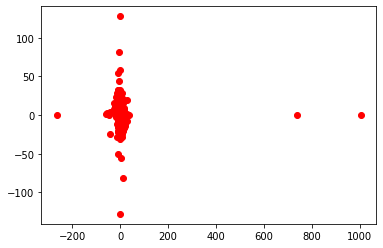

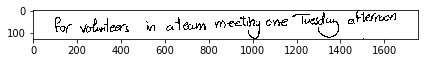

In [21]:
approx_image = PolyApproxMethod(thresh_img, approx_factor = 0.01)
cold_dist = distribution(approx_image)
feature_vector = calculateFeatureVector(cold_dist, 4, 4)
cold_dist = convertPolarToSpatial(cold_dist)
# print(cold_dist)
# print(type(cold_dist))
print(feature_vector)
plt.plot(cold_dist[:, 0], cold_dist[:, 1], 'ro')
plt.show()
io.imshow(thresh_img)
io.show()
# print(cold_dist)